In [ ]:
import datetime as dt
import pandas as pd
import io
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns

sns.set(style='darkgrid', context='talk', palette='Dark2')

from sklearn.preprocessing import OneHotEncoder
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
uploaded = files.upload()

Saving yfinance.csv to yfinance.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['yfinance.csv']))
df = df.iloc[:, 1:]


In [ ]:
#check for missing data
df.isna().sum()

Date         0
Symbol       0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
ticker       0
industry     0
dtype: int64

In [ ]:
#check data types
df.dtypes

Date          object
Symbol        object
Adj Close    float64
Close        float64
High         float64
Low          float64
Open         float64
Volume       float64
ticker        object
industry      object
dtype: object

In [ ]:
df.shape

(90833, 10)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

Make the target variable. For our purposes the target is a 1,0 where 1 represents an equity whose opening price increased week over week (Monday to the next Monday)

In [ ]:
def create_target(df):
  df['weekly_price_change'] = df.groupby('Symbol')['Open'].diff()
  df['target'] = np.where(df['weekly_price_change'].shift(-1) >= 0 ,1,0)
  return df

In [ ]:
df = create_target(df)


In [ ]:
df['target'].describe()


count    90833.000000
mean         0.533573
std          0.498874
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: target, dtype: float64

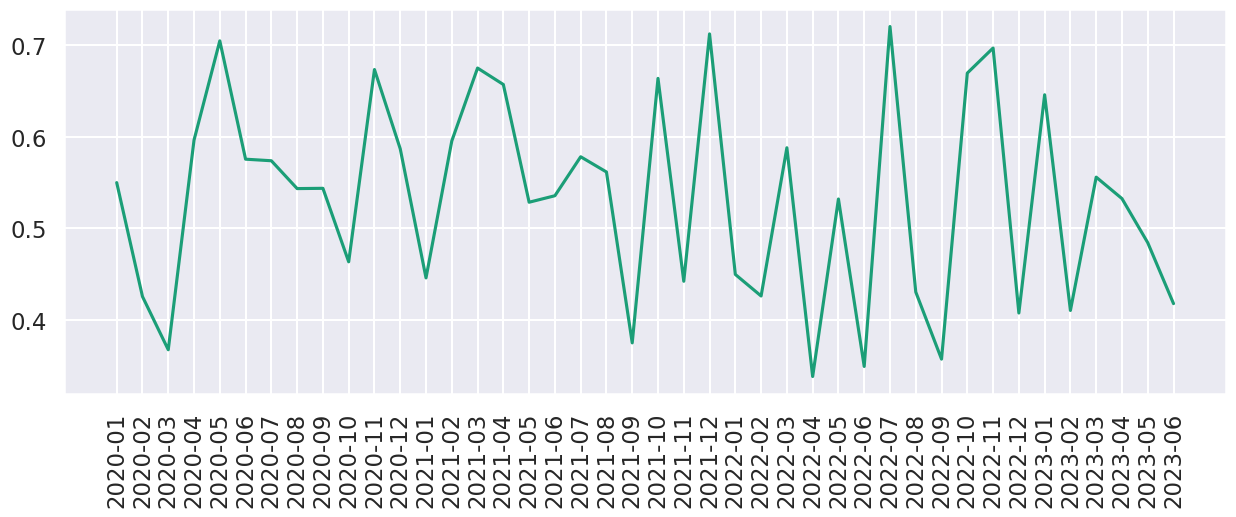

In [ ]:
monthly_target_avg = df.groupby(pd.PeriodIndex(df['Date'], freq="M"))['target'].mean().reset_index()

plt.figure(figsize=(15,5))
plt.plot(monthly_target_avg["Date"].astype('str'), monthly_target_avg["target"], label = 'avg')
plt.xticks(rotation=90)
plt.show()

In [ ]:
monthly_target_avg.describe()

,target
count,42.000000
mean,0.532970
std,0.111749
min,0.338000
25%,0.433321
50%,0.543524
75%,0.596135
max,0.720500


In [ ]:
def momentum_features(df):
  df['2wk_open_avg'] = df.groupby('Symbol')['Open'].rolling(2).mean().reset_index(level=0,drop=True)
  df['ema_2wk'] = df.groupby('Symbol')['Open'].ewm(span=2, adjust=False).mean().reset_index(level=0,drop=True)
  df['4wk_open_avg'] = df.groupby('Symbol')['Open'].rolling(4).mean().reset_index(level=0,drop=True)
  df['ema_4wk'] = df.groupby('Symbol')['Open'].ewm(span=4, adjust=False).mean().reset_index(level=0,drop=True)
  df['6wk_open_avg'] = df.groupby('Symbol')['Open'].rolling(6).mean().reset_index(level=0,drop=True)
  df['ema_6wk'] = df.groupby('Symbol')['Open'].ewm(span=6, adjust=False).mean().reset_index(level=0,drop=True)

  df['2wk_vol_avg'] = df.groupby('Symbol')['Volume'].rolling(2).mean().reset_index(level=0,drop=True)
  df['ema_vol2wk'] = df.groupby('Symbol')['Volume'].ewm(span=2, adjust=False).mean().reset_index(level=0,drop=True)
  df['4wk_vol_avg'] = df.groupby('Symbol')['Volume'].rolling(4).mean().reset_index(level=0,drop=True)
  df['ema_vol4wk'] = df.groupby('Symbol')['Volume'].ewm(span=4, adjust=False).mean().reset_index(level=0,drop=True)
  df['6wk_vol_avg'] = df.groupby('Symbol')['Volume'].rolling(6).mean().reset_index(level=0,drop=True)
  df['ema_vol6wk'] = df.groupby('Symbol')['Volume'].ewm(span=6, adjust=False).mean().reset_index(level=0,drop=True)

  df['ema_9wk'] = df.groupby('Symbol')['Open'].ewm(span=9, adjust=False).mean().reset_index(level=0,drop=True)
  df['MACD_9_4'] = df['ema_4wk'] - df['ema_9wk']
  df['MACD_signal_9_4'] = df.groupby('Symbol')['MACD_9_4'].ewm(span=4, adjust=False).mean().reset_index(level=0,drop=True)

  df['ema_12wk'] = df.groupby('Symbol')['Open'].ewm(span=12, adjust=False).mean().reset_index(level=0,drop=True)
  df['MACD_12_6'] = df['ema_12wk'] - df['ema_6wk']
  df['MACD_signal_12_6'] = df.groupby('Symbol')['MACD_12_6'].ewm(span=4, adjust=False).mean().reset_index(level=0,drop=True)

  return df

df = momentum_features(df)

In [ ]:
df.columns

Index(['Date', 'Symbol', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'ticker', 'industry', 'weekly_price_change', 'target', '2wk_open_avg',
       'ema_2wk', '4wk_open_avg', 'ema_4wk', '6wk_open_avg', 'ema_6wk',
       '2wk_vol_avg', 'ema_vol2wk', '4wk_vol_avg', 'ema_vol4wk', '6wk_vol_avg',
       'ema_vol6wk', 'ema_9wk', 'MACD_9_4', 'MACD_signal_9_4', 'ema_12wk',
       'MACD_12_6', 'MACD_signal_12_6'],
      dtype='object')

Create momentum features for each industry

In [ ]:
industry = df.groupby(['industry','Date'])['Open'].sum().reset_index()
ind_vol = df.groupby(['industry','Date'])['Volume'].sum().reset_index()
industry.columns

Index(['industry', 'Date', 'Open'], dtype='object')

In [ ]:
industry['ind_2wk_open_avg'] = industry.groupby('industry')['Open'].rolling(2).mean().reset_index(level=0,drop=True)
industry['ind_ema_2wk'] = industry.groupby('industry')['Open'].ewm(span=2, adjust=False).mean().reset_index(level=0,drop=True)
industry['ind_4wk_open_avg'] = industry.groupby('industry')['Open'].rolling(4).mean().reset_index(level=0,drop=True)
industry['ind_ema_4wk'] = industry.groupby('industry')['Open'].ewm(span=4, adjust=False).mean().reset_index(level=0,drop=True)
industry['ind_6wk_open_avg'] = industry.groupby('industry')['Open'].rolling(6).mean().reset_index(level=0,drop=True)
industry['ind_ema_6wk'] = industry.groupby('industry')['Open'].ewm(span=6, adjust=False).mean().reset_index(level=0,drop=True)

ind_vol['ind_2wk_vol_avg'] = ind_vol.groupby('industry')['Volume'].rolling(2).mean().reset_index(level=0,drop=True)
ind_vol['ind_ema_vol2wk'] = ind_vol.groupby('industry')['Volume'].ewm(span=2, adjust=False).mean().reset_index(level=0,drop=True)
ind_vol['ind_4wk_vol_avg'] = ind_vol.groupby('industry')['Volume'].rolling(4).mean().reset_index(level=0,drop=True)
ind_vol['ind_ema_vol4wk'] = ind_vol.groupby('industry')['Volume'].ewm(span=4, adjust=False).mean().reset_index(level=0,drop=True)
ind_vol['ind_6wk_vol_avg'] = ind_vol.groupby('industry')['Volume'].rolling(6).mean().reset_index(level=0,drop=True)
ind_vol['ind_ema_vol6wk'] = ind_vol.groupby('industry')['Volume'].ewm(span=6, adjust=False).mean().reset_index(level=0,drop=True)


In [ ]:
ind = industry.merge(ind_vol, how = 'left', on = ['industry','Date'])
print(ind.head())
print(ind.columns)

                 industry       Date         Open  ind_2wk_open_avg  \
0  Communication Services 2020-01-06  2234.510118               NaN   
1  Communication Services 2020-01-13  2288.797756       2261.653937   
2  Communication Services 2020-01-20  2325.791276       2307.294516   
3  Communication Services 2020-01-27  2259.393046       2292.592161   
4  Communication Services 2020-02-03  2273.603197       2266.498122   

   ind_ema_2wk  ind_4wk_open_avg  ind_ema_4wk  ind_6wk_open_avg  ind_ema_6wk  \
0  2234.510118               NaN  2234.510118               NaN  2234.510118   
1  2270.701877               NaN  2256.225173               NaN  2250.020871   
2  2307.428143               NaN  2284.051614               NaN  2271.669558   
3  2275.404745       2277.123049  2274.188187               NaN  2268.161984   
4  2274.203713       2286.896319  2273.954191               NaN  2269.716616   

         Volume  ind_2wk_vol_avg  ind_ema_vol2wk  ind_4wk_vol_avg  \
0  1.056517e+09        

In [ ]:
full = df.merge(ind, how = 'left', on = ['industry','Date'])
print(full.head())
print(full.shape)
print(full.columns)

        Date Symbol  Adj Close      Close       High        Low     Open_x  \
0 2020-01-06      A  85.549835  87.589996  88.239998  83.599998  84.000000   
1 2020-01-13      A  88.020920  90.120003  90.279999  86.699997  87.809998   
2 2020-01-20      A  86.204269  88.260002  90.639999  87.580002  89.800003   
3 2020-01-27      A  80.637001  82.559998  88.360001  82.339996  86.540001   
4 2020-02-03      A  81.232796  83.169998  85.500000  82.110001  83.290001   

     Volume_x ticker     industry  ...   ind_ema_4wk  ind_6wk_open_avg  \
0   8855200.0      A  Health Care  ...  10346.028339               NaN   
1  10250000.0      A  Health Care  ...  10474.672477               NaN   
2   6756000.0      A  Health Care  ...  10594.491965               NaN   
3  10528800.0      A  Health Care  ...  10536.681767               NaN   
4   8224000.0      A  Health Care  ...  10431.583105               NaN   

    ind_ema_6wk      Volume_y  ind_2wk_vol_avg  ind_ema_vol2wk  \
0  10346.028339  8.0

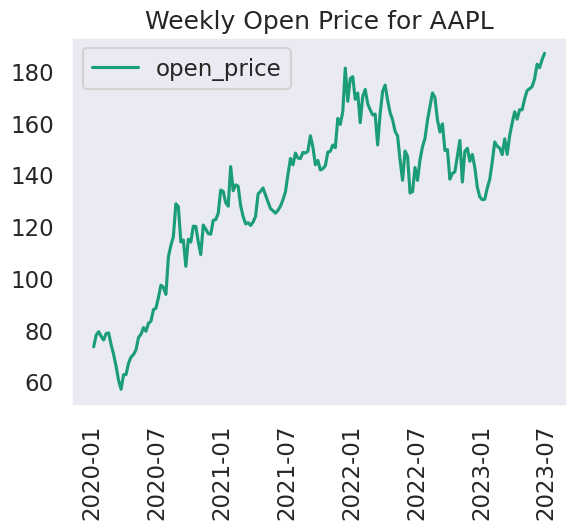

In [ ]:
aapl = full[full['Symbol']=='AAPL']

plt.plot(aapl["Date"], aapl["Open_x"], label = 'open_price')
plt.xticks(rotation=90)
plt.grid(False)
plt.legend(loc="upper left")
plt.title("Weekly Open Price for AAPL")
plt.show()

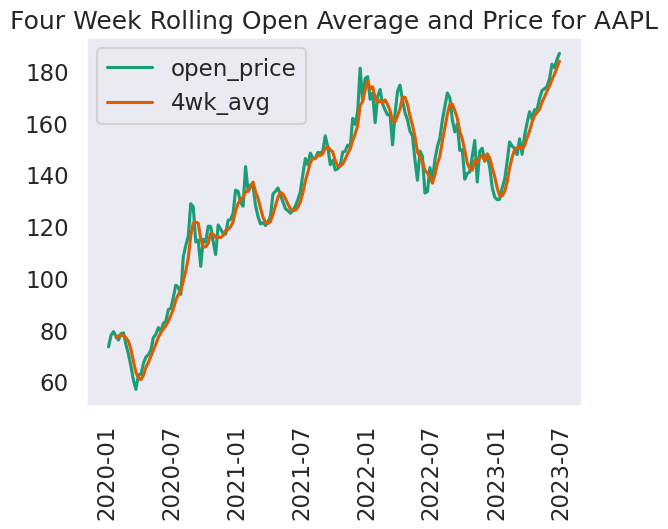

In [ ]:
aapl = full[full['Symbol']=='AAPL']

plt.plot(aapl["Date"], aapl["Open_x"], label = 'open_price')
plt.plot(aapl["Date"], aapl["4wk_open_avg"], label = '4wk_avg')
plt.xticks(rotation=90)
plt.grid(False)
plt.legend(loc="upper left")
plt.title("Four Week Rolling Open Average and Price for AAPL")
plt.show()

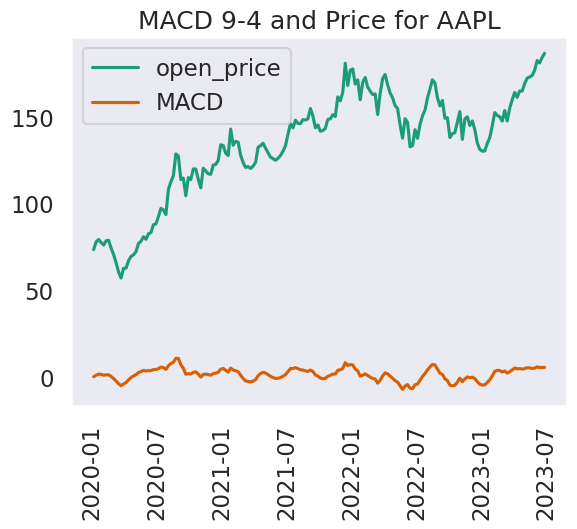

In [ ]:
aapl = full[full['Symbol']=='AAPL']

plt.plot(aapl["Date"], aapl["Open_x"], label = 'open_price')
plt.plot(aapl["Date"], aapl["MACD_9_4"], label = 'MACD')
plt.xticks(rotation=90)
plt.grid(False)
plt.legend(loc="upper left")
plt.title("MACD 9-4 and Price for AAPL")
plt.show()

In [ ]:

corr = full.corr()
corr.style.background_gradient(cmap='coolwarm')

<ipython-input-22-fc441cdbdb99>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = full.corr()


,Adj Close,Close,High,Low,Open_x,Volume_x,weekly_price_change,target,2wk_open_avg,ema_2wk,4wk_open_avg,ema_4wk,6wk_open_avg,ema_6wk,2wk_vol_avg,ema_vol2wk,4wk_vol_avg,ema_vol4wk,6wk_vol_avg,ema_vol6wk,ema_9wk,MACD_9_4,MACD_signal_9_4,ema_12wk,MACD_12_6,MACD_signal_12_6,Open_y,ind_2wk_open_avg,ind_ema_2wk,ind_4wk_open_avg,ind_ema_4wk,ind_6wk_open_avg,ind_ema_6wk,Volume_y,ind_2wk_vol_avg,ind_ema_vol2wk,ind_4wk_vol_avg,ind_ema_vol4wk,ind_6wk_vol_avg,ind_ema_vol6wk
Adj Close,1.000000,0.999870,0.999333,0.999300,0.998641,-0.104597,0.075777,0.014097,0.998419,0.998566,0.997720,0.998135,0.997036,0.997674,-0.106607,-0.106636,-0.108422,-0.107930,-0.109515,-0.108351,0.996991,0.271464,0.293014,0.996319,-0.313768,-0.325669,0.231132,0.230959,0.231023,0.230545,0.230715,0.230130,0.230415,0.095634,0.098282,0.099046,0.101038,0.102497,0.102966,0.104829
Close,0.999870,1.000000,0.999442,0.999451,0.998770,-0.106432,0.075876,0.014422,0.998545,0.998693,0.997839,0.998258,0.997148,0.997792,-0.108469,-0.108509,-0.110295,-0.109830,-0.111385,-0.110261,0.997103,0.271806,0.293366,0.996426,-0.314159,-0.326069,0.228523,0.228369,0.228406,0.227992,0.228083,0.227615,0.227768,0.093773,0.096395,0.097122,0.099164,0.100525,0.101139,0.102835
High,0.999333,0.999442,1.000000,0.999167,0.999427,-0.105171,0.074083,0.004791,0.999253,0.999401,0.998668,0.999060,0.998076,0.998666,-0.107455,-0.107416,-0.109466,-0.108909,-0.110646,-0.109430,0.998066,0.267080,0.289011,0.997465,-0.309335,-0.321577,0.228611,0.228497,0.228546,0.228189,0.228300,0.227863,0.228036,0.098241,0.100119,0.101086,0.102256,0.103922,0.103921,0.105915
Low,0.999300,0.999451,0.999167,1.000000,0.999323,-0.107729,0.080973,0.006290,0.998966,0.999131,0.998081,0.998534,0.997252,0.997948,-0.109624,-0.109705,-0.111323,-0.110909,-0.112329,-0.111273,0.997120,0.279798,0.300516,0.996332,-0.321845,-0.332854,0.229036,0.228825,0.228857,0.228375,0.228432,0.227929,0.228032,0.090253,0.092721,0.093544,0.095729,0.097082,0.097912,0.099555
Open_x,0.998641,0.998770,0.999427,0.999323,1.000000,-0.106623,0.080686,-0.003876,0.999653,0.999837,0.998891,0.999315,0.998138,0.998790,-0.108761,-0.108765,-0.110640,-0.110137,-0.111724,-0.110587,0.998038,0.275798,0.296753,0.997315,-0.317740,-0.329003,0.229141,0.228940,0.228995,0.228530,0.228634,0.228114,0.228284,0.094286,0.095894,0.097020,0.098347,0.100000,0.100277,0.102173
Volume_x,-0.104597,-0.106432,-0.105171,-0.107729,-0.106623,1.000000,-0.005045,-0.011559,-0.106918,-0.106686,-0.107388,-0.106773,-0.108923,-0.106848,0.981626,0.993142,0.960612,0.978157,0.951915,0.968216,-0.106943,-0.020132,-0.022159,-0.107017,0.023996,0.025406,0.002002,0.002357,0.002572,0.002844,0.003404,0.002886,0.003979,0.192418,0.185274,0.188559,0.176738,0.182044,0.173964,0.177858
weekly_price_change,0.075777,0.075876,0.074083,0.080973,0.080686,-0.005045,1.000000,-0.002052,0.054402,0.063672,0.042320,0.050979,0.041009,0.046039,-0.004410,-0.004137,-0.001742,-0.002561,-0.000664,-0.001652,0.042673,0.265223,0.094127,0.041005,-0.166323,-0.055274,0.023402,0.011239,0.015390,0.005541,0.009258,0.003890,0.006928,-0.026555,-0.021559,-0.018545,0.002297,-0.005057,0.013163,0.002332
target,0.014097,0.014422,0.004791,0.006290,-0.003876,-0.011559,-0.002052,1.000000,-0.003931,-0.003831,-0.003986,-0.003606,-0.003369,-0.003351,-0.004845,-0.007093,-0.000762,-0.003296,-0.000156,-0.001684,-0.003063,-0.017421,-0.016699,-0.002876,0.015446,0.012792,-0.015784,-0.016001,-0.015793,-0.015364,-0.015233,-0.013844,-0.014503,-0.027249,0.004699,-0.007260,0.019714,0.008125,0.022884,0.014024
2wk_open_avg,0.998419,0.998545,0.999253,0.998966,0.999653,-0.106918,0.054402,-0.003931,1.000000,0.999939,0.999532,0.999749,0.998865,0.999352,-0.108839,-0.109113,-0.110789,-0.110545,-0.111909,-0.111027,0.998685,0.269728,0.295276,0.998003,-0.314428,-0.328664,0.228947,0.229058,0.229013,0.228794,0.228814,0.228434,0.228525,0.094891,0.096642,0.097421,0.098460,0.100054,0.100103,0.102040
ema_2wk,0.998566,0.998693,0.999401,0.999131,0.999837,-0.106686,0.063672,-0.003831,0.999939,1.00000

In [ ]:
ind_avg = full.groupby('industry')['target'].mean()


industry
Communication Services    0.520545
Consumer Discretionary    0.529131
Consumer Staples          0.533425
Energy                    0.534400
Financials                0.538539
Health Care               0.528991
Industrials               0.538667
Information Technology    0.541906
Materials                 0.541872
Real Estate               0.515751
Utilities                 0.527456
Name: target, dtype: float64

In [ ]:
full.to_csv('full_features.csv')